In [8]:
import pandas as pd
from nltk import word_tokenize
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

twitter_df = pd.read_csv('processed_cyberbullying_tweets.csv')
tweets = twitter_df['processed_tweet_text'].astype(str).tolist()

tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in tweets]
model_w2v = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

model_w2v.wv['food']


vocab_size = len(model_w2v.wv.key_to_index)
vocab_size

twitter_df['word_embeddings'] = twitter_df.apply(lambda x : list(), axis=1)

for index, row in twitter_df.iterrows():
    for word in word_tokenize(str(row['processed_tweet_text']).lower()):
        row['word_embeddings'].append(model_w2v.wv[word])
    while len(row['word_embeddings']) < 50:
        row['word_embeddings'].append([0]*100)
    

len(twitter_df.loc[0, 'word_embeddings'])
len(twitter_df.loc[0, 'word_embeddings'][0])


model_w2v.wv['words']

from sklearn.model_selection import train_test_split

X = twitter_df['word_embeddings'].tolist()
y = twitter_df['cyberbullying_type'].tolist()

data_0 = twitter_df[twitter_df['cyberbullying_type'] == 0]
data_1 = twitter_df[twitter_df['cyberbullying_type'] == 1]

sampled_data_0 = data_0.sample(n=7000, random_state=42)
sampled_data_1 = data_1.sample(n=20000, random_state=42)

balanced_df = pd.concat([sampled_data_0, sampled_data_1])

X_dec = balanced_df['word_embeddings'].tolist()
y_dec = balanced_df['cyberbullying_type'].tolist()

# Shuffle the resulting DataFrame to mix the examples of 0s and 1s
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X_dec, y_dec, test_size=0.3, random_state=42)

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming X_train, X_test are lists of lists of word embeddings, and y_train, y_test are labels
# Since the input data is already in the form of embeddings, we don't need an embedding layer


In [21]:

# Padding sequences to ensure uniform input size
max_length = max(max(len(seq) for seq in X_train), max(len(seq) for seq in X_test))
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', dtype='float32')

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.precision_scores = []
        self.recall_scores = []
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_test)
        y_pred = np.round(y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        self.precision_scores.append(precision)
        self.recall_scores.append(recall)
        self.f1_scores.append(f1)

metrics_callback = MetricsCallback(X_test_padded, y_test)

In [22]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(max_length, 100)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class classification

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use 'categorical_crossentropy' for multi-class classification

# Training the model
history = model.fit(X_train_padded, np.array(y_train), epochs=5, batch_size=64, validation_split=0.2, callbacks=[metrics_callback])

# Now you can access metrics using history.history
print(history.history.keys())

# Evaluating the model
loss, accuracy = model.evaluate(X_test_padded, np.array(y_test))
print(f'Test Accuracy: {accuracy}')

Epoch 1/5
62/62 [==============================] - 18s 247ms/step - loss: 0.4652 - accuracy: 0.7500 - val_loss: 0.3753 - val_accuracy: 0.8031
Epoch 2/5
62/62 [==============================] - 12s 194ms/step - loss: 0.3759 - accuracy: 0.8008 - val_loss: 0.3718 - val_accuracy: 0.8041
Epoch 3/5
62/62 [==============================] - 12s 195ms/step - loss: 0.3604 - accuracy: 0.8038 - val_loss: 0.3499 - val_accuracy: 0.8082
Epoch 4/5
62/62 [==============================] - 12s 196ms/step - loss: 0.3635 - accuracy: 0.8005 - val_loss: 0.3476 - val_accuracy: 0.8173
Epoch 5/5
62/62 [==============================] - 14s 232ms/step - loss: 0.3532 - accuracy: 0.8094 - val_loss: 0.3418 - val_accuracy: 0.8133
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
66/66 [==============================] - 2s 32ms/step - loss: 0.3662 - accuracy: 0.8081
Test Accuracy: 0.8080952167510986


In [23]:
def predict_sentiment(sentence, model, word2vec_model):
    # Tokenize and convert to embeddings
    tokens = word_tokenize(sentence.lower())
    print(tokens)
    embeddings = [word2vec_model.wv[token] if token in word2vec_model.wv else np.zeros(100) for token in tokens]
    
    # Pad the sequence
    padded_embeddings = pad_sequences([embeddings], maxlen=max_length, padding='post', dtype='float32')
    print(padded_embeddings)
    # Predict
    prediction = model.predict(padded_embeddings)
    print(prediction)
    # Assuming binary classification with a sigmoid output layer
    predicted_label = 'Positive' if prediction[0][0] < 0.5 else 'Negative'
    
    return predicted_label, prediction[0][0]

# Example usage
test_sentence = "bing bong"
predicted_label, confidence = predict_sentiment(test_sentence, model, model_w2v)

print(f"Sentence: '{test_sentence}'")
print(f"Predicted Sentiment: {predicted_label} (Confidence: {confidence:.2f})")

['bing', 'bong']
[[[-0.01962559  0.00869128  0.01387207 ... -0.01857436  0.00284418
    0.02140067]
  [ 0.00021635  0.01503865  0.0109548  ...  0.000648    0.00466802
   -0.00266123]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]]
1/1 [==============================] - 0s 24ms/step
[[0.48594972]]
Sentence: 'bing bong'
Predicted Sentiment: Positive (Confidence: 0.49)


66/66 [==============================] - 3s 38ms/step
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       628
           1       0.90      0.82      0.86      1472

    accuracy                           0.81      2100
   macro avg       0.77      0.80      0.78      2100
weighted avg       0.82      0.81      0.81      2100



<Axes: >

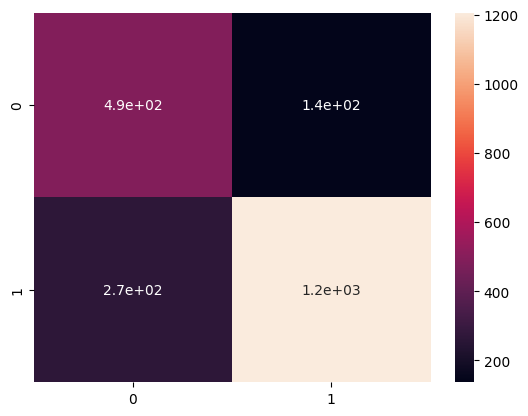

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5)
y_pred = y_pred.astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

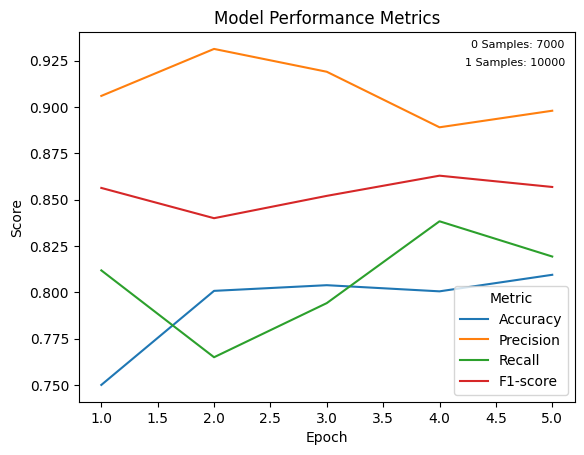

In [27]:
epochs = range(1, len(history.history['loss']) + 1)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
precision = metrics_callback.precision_scores
recall = metrics_callback.recall_scores
f1 = metrics_callback.f1_scores

data = pd.DataFrame({'Epoch': epochs, 'Accuracy': accuracy, 'Precision': precision, 
                     'Recall': recall, 'F1-score': f1})
data = pd.melt(data, id_vars=['Epoch'], var_name='Metric', value_name='Score')

sns.lineplot(x='Epoch', y='Score', hue='Metric', data=data)
plt.title('Model Performance Metrics')

plt.text(0.98, 0.98, f'0 Samples: {7000}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize=8)
plt.text(0.98, 0.93, f'1 Samples: {10000}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize=8)

plt.show()